In [1]:
 pip install libauc==1.3.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.9/123.9 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.8/54.8 MB 24.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 MB 22.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 20.4 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
from libauc.losses import CrossEntropyLoss

import torch
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import top_k_accuracy_score
from sklearn.datasets import load_svmlight_file
from sklearn.preprocessing import StandardScaler
import numpy as np

In [5]:
class LibSVMDataset(Dataset):
    def __init__(self, data, targets):
       self.data = data
       self.targets = targets
       self.targets[targets==2] = 0 # convert 2 to 0 for breast-cancer dataset only
       self.targets[targets==4] = 1 # convert 4 to 1 for breast-cancer dataset only

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        data = self.data[idx].astype(np.float32)
        target = self.targets[idx].astype(np.int64)
        return data, target

In [7]:
#A mini example of SGD optimizer
class SGD(torch.optim.Optimizer):
    def __init__(self, params, lr=0.1, weight_decay=0.0):
        self.lr = lr
        defaults = dict(lr=lr, weight_decay=weight_decay)
        super(SGD, self).__init__(params, defaults)

    @torch.no_grad()
    def step(self, closure=None):
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            weight_decay = group['weight_decay']
            self.lr = group['lr']
            for p in group['params']:
                d_p = p.grad
                # update the model parameters
                ### YOUR CODE HERE
                p -= self.lr * d_p
                ### YOUR CODE HERE

        return loss

In [9]:
class linear_model(torch.nn.Module):
    def __init__(self, input_dim=10, output_dim=1):
        super().__init__()
        self.classifer = torch.nn.Linear(input_dim, output_dim)
    def forward(self, x):
        return self.classifer(x)

In [19]:
def step_decay(epoch, initial_lr, decay_rate, t0):
    return initial_lr * (decay_rate ** (epoch // t0))

def cosine_decay(epoch, initial_lr, min_lr, total_epochs):
    return min_lr + 0.5 * (initial_lr - min_lr) * (1 + np.cos(epoch * np.pi / total_epochs))

def polynomial_decay(epoch, initial_lr, alpha):
    return initial_lr * (1 - epoch / total_epochs) ** alpha

In [104]:
BATCH_SIZE = 16
total_epochs = 30
learning_rates = [0.1, 0.3, 1, 3, 10]
min_lr = 0.001
t0 = 15
decay_rate = 0.1
alpha = 0.5

Training with initial learning rate: 0.1
Epoch: 1, Loss: 0.2646, LR: 0.1000
Epoch: 2, Loss: 0.1167, LR: 0.1000
Epoch: 3, Loss: 0.0987, LR: 0.1000
Epoch: 4, Loss: 0.0920, LR: 0.1000
Epoch: 5, Loss: 0.0881, LR: 0.1000
Epoch: 6, Loss: 0.0873, LR: 0.1000
Epoch: 7, Loss: 0.0840, LR: 0.1000
Epoch: 8, Loss: 0.0834, LR: 0.1000
Epoch: 9, Loss: 0.0820, LR: 0.1000
Epoch: 10, Loss: 0.0809, LR: 0.1000
Epoch: 11, Loss: 0.0808, LR: 0.1000
Epoch: 12, Loss: 0.0824, LR: 0.1000
Epoch: 13, Loss: 0.0800, LR: 0.1000
Epoch: 14, Loss: 0.0789, LR: 0.1000
Epoch: 15, Loss: 0.0795, LR: 0.1000
Epoch: 16, Loss: 0.0783, LR: 0.0100
Epoch: 17, Loss: 0.0779, LR: 0.0100
Epoch: 18, Loss: 0.0777, LR: 0.0100
Epoch: 19, Loss: 0.0797, LR: 0.0100
Epoch: 20, Loss: 0.0776, LR: 0.0100
Epoch: 21, Loss: 0.0772, LR: 0.0100
Epoch: 22, Loss: 0.0783, LR: 0.0100
Epoch: 23, Loss: 0.0770, LR: 0.0100
Epoch: 24, Loss: 0.0770, LR: 0.0100
Epoch: 25, Loss: 0.0767, LR: 0.0100
Epoch: 26, Loss: 0.0766, LR: 0.0100
Epoch: 27, Loss: 0.0766, LR: 0.0

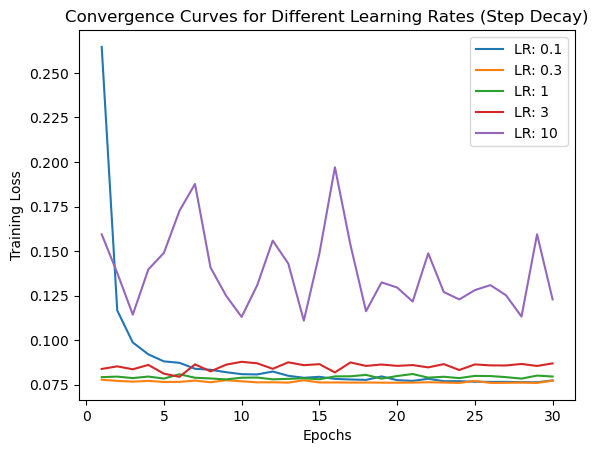

In [120]:
best_loss_step = float('inf')
best_lr_step= None
best_curve_step = None
best_convergences_step = {}
def main():
    # load data, labels as numpy arrays
    X_train, y_train = load_svmlight_file("breast-cancer_scale")
    scaler = StandardScaler()
    X_train = X_train.toarray()
    X_train = scaler.fit_transform(X_train)
    train_set = LibSVMDataset(X_train, y_train)
    train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)

    # define model
    feat_dim = X_train.shape[1]
    model = linear_model(input_dim=feat_dim)

    # define loss 
    loss_fn = CrossEntropyLoss()

    # For plotting
    results = {}
    global best_loss_step, best_lr_step, best_curve_step
    for initial_lr in learning_rates:
        print(f"Training with initial learning rate: {initial_lr}")
        optimizer = SGD(model.parameters(), lr=initial_lr)
        train_log = []

        for epoch in range(total_epochs):
            model.train()
            epoch_loss = []
            for data, targets in train_loader:
                y_pred = model(data)
                loss = loss_fn(y_pred.squeeze(), targets.float())
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # Decay the learning rate
                optimizer.lr = step_decay(epoch, initial_lr, decay_rate, t0)  

                epoch_loss.append(loss.item())

            train_loss = np.mean(epoch_loss)
            train_log.append(train_loss)
            if train_loss < best_loss_step:
                    best_loss_step = train_loss
                    best_lr_step = initial_lr
                    best_curve_step= train_log 
            print(f"Epoch: {epoch + 1}, Loss: {train_loss:.4f}, LR: {optimizer.lr:.4f}")

        results[initial_lr] = train_log

    # Plotting the results
    for lr, losses in results.items():
        plt.plot(range(1, total_epochs + 1), losses, label=f'LR: {lr}')

    plt.title('Convergence Curves for Different Learning Rates (Step Decay)')
    plt.xlabel('Epochs')
    plt.ylabel('Training Loss')
    plt.legend()
    plt.show()
main()

Training with initial learning rate: 0.1
Epoch: 1, Loss: 0.2067, LR: 0.1000
Epoch: 2, Loss: 0.1125, LR: 0.0997
Epoch: 3, Loss: 0.0970, LR: 0.0989
Epoch: 4, Loss: 0.0952, LR: 0.0976
Epoch: 5, Loss: 0.0874, LR: 0.0957
Epoch: 6, Loss: 0.0861, LR: 0.0934
Epoch: 7, Loss: 0.0836, LR: 0.0905
Epoch: 8, Loss: 0.0828, LR: 0.0873
Epoch: 9, Loss: 0.0817, LR: 0.0836
Epoch: 10, Loss: 0.0811, LR: 0.0796
Epoch: 11, Loss: 0.0805, LR: 0.0753
Epoch: 12, Loss: 0.0799, LR: 0.0706
Epoch: 13, Loss: 0.0795, LR: 0.0658
Epoch: 14, Loss: 0.0792, LR: 0.0608
Epoch: 15, Loss: 0.0788, LR: 0.0557
Epoch: 16, Loss: 0.0785, LR: 0.0505
Epoch: 17, Loss: 0.0783, LR: 0.0453
Epoch: 18, Loss: 0.0781, LR: 0.0402
Epoch: 19, Loss: 0.0780, LR: 0.0352
Epoch: 20, Loss: 0.0778, LR: 0.0304
Epoch: 21, Loss: 0.0780, LR: 0.0258
Epoch: 22, Loss: 0.0775, LR: 0.0214
Epoch: 23, Loss: 0.0774, LR: 0.0174
Epoch: 24, Loss: 0.0774, LR: 0.0137
Epoch: 25, Loss: 0.0771, LR: 0.0105
Epoch: 26, Loss: 0.0770, LR: 0.0076
Epoch: 27, Loss: 0.0790, LR: 0.0

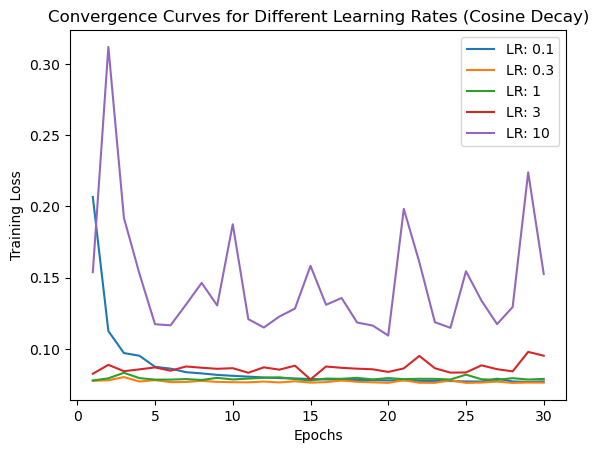

In [122]:
best_loss_cos = float('inf')
best_lr_cos= None
best_curve_cos = None
best_convergences_cos = {}
def main():
    # load data, labels as numpy arrays
    X_train, y_train = load_svmlight_file("breast-cancer_scale")
    scaler = StandardScaler()
    X_train = X_train.toarray()
    X_train = scaler.fit_transform(X_train)
    train_set = LibSVMDataset(X_train, y_train)
    train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)

    # define model
    feat_dim = X_train.shape[1]
    model = linear_model(input_dim=feat_dim)

    # define loss function
    loss_fn = CrossEntropyLoss()

    # For plotting
    results = {}
    global best_loss_cos, best_lr_cos, best_curve_cos
    for initial_lr in learning_rates:
        print(f"Training with initial learning rate: {initial_lr}")
        optimizer = SGD(model.parameters(), lr=initial_lr)
        train_log = []

        for epoch in range(total_epochs):
            model.train()
            epoch_loss = []
            for data, targets in train_loader:
                y_pred = model(data)
                loss = loss_fn(y_pred.squeeze(), targets.float())
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # Decay the learning rate
                optimizer.lr = cosine_decay(epoch, initial_lr, min_lr, total_epochs) 

                epoch_loss.append(loss.item())

            train_loss = np.mean(epoch_loss)
            train_log.append(train_loss)
            if train_loss < best_loss_cos:
                    best_loss_cos = train_loss
                    best_lr_cos = initial_lr
                    best_curve_cos = train_log 
            print(f"Epoch: {epoch + 1}, Loss: {train_loss:.4f}, LR: {optimizer.lr:.4f}")

        results[initial_lr] = train_log

    # Plotting the results
    for lr, losses in results.items():
        plt.plot(range(1, total_epochs + 1), losses, label=f'LR: {lr}')

    plt.title('Convergence Curves for Different Learning Rates (Cosine Decay)')
    plt.xlabel('Epochs')
    plt.ylabel('Training Loss')
    plt.legend()
    plt.show()
main()

Training with initial learning rate: 0.1
Epoch: 1, Loss: 0.2620, LR: 0.1000
Epoch: 2, Loss: 0.1222, LR: 0.0983
Epoch: 3, Loss: 0.1030, LR: 0.0966
Epoch: 4, Loss: 0.0977, LR: 0.0949
Epoch: 5, Loss: 0.0910, LR: 0.0931
Epoch: 6, Loss: 0.0889, LR: 0.0913
Epoch: 7, Loss: 0.0877, LR: 0.0894
Epoch: 8, Loss: 0.0845, LR: 0.0876
Epoch: 9, Loss: 0.0832, LR: 0.0856
Epoch: 10, Loss: 0.0822, LR: 0.0837
Epoch: 11, Loss: 0.0812, LR: 0.0816
Epoch: 12, Loss: 0.0808, LR: 0.0796
Epoch: 13, Loss: 0.0799, LR: 0.0775
Epoch: 14, Loss: 0.0801, LR: 0.0753
Epoch: 15, Loss: 0.0789, LR: 0.0730
Epoch: 16, Loss: 0.0786, LR: 0.0707
Epoch: 17, Loss: 0.0783, LR: 0.0683
Epoch: 18, Loss: 0.0788, LR: 0.0658
Epoch: 19, Loss: 0.0778, LR: 0.0632
Epoch: 20, Loss: 0.0778, LR: 0.0606
Epoch: 21, Loss: 0.0788, LR: 0.0577
Epoch: 22, Loss: 0.0771, LR: 0.0548
Epoch: 23, Loss: 0.0796, LR: 0.0516
Epoch: 24, Loss: 0.0771, LR: 0.0483
Epoch: 25, Loss: 0.0787, LR: 0.0447
Epoch: 26, Loss: 0.0778, LR: 0.0408
Epoch: 27, Loss: 0.0766, LR: 0.0

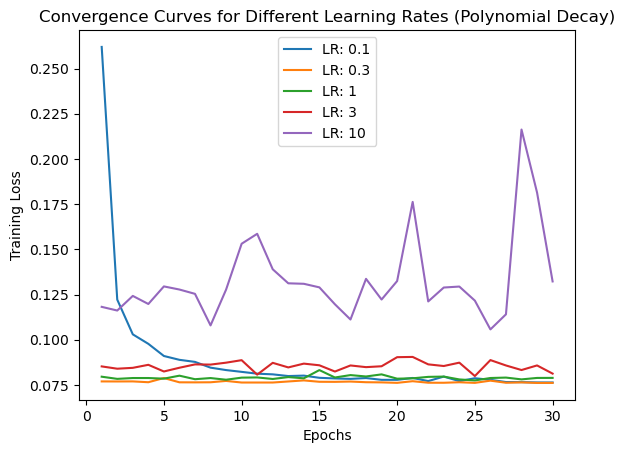

In [124]:
best_loss_poly = float('inf')
best_lr_poly = None
best_curve_poly = None
best_convergences_poly = {}
def main():
    # load data, labels as numpy arrays
    X_train, y_train = load_svmlight_file("breast-cancer_scale")
    scaler = StandardScaler()
    X_train = X_train.toarray()
    X_train = scaler.fit_transform(X_train)
    train_set = LibSVMDataset(X_train, y_train)
    train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)

    # Define model
    feat_dim = X_train.shape[1]
    model = linear_model(input_dim=feat_dim)

    # Define loss function
    loss_fn = CrossEntropyLoss()

    # For plotting
    results = {}
    global best_loss_poly, best_lr_poly, best_curve_poly
    for initial_lr in learning_rates:
        print(f"Training with initial learning rate: {initial_lr}")
        optimizer = SGD(model.parameters(), lr=initial_lr)
        train_log = []

        for epoch in range(total_epochs):
            model.train()
            epoch_loss = []
            for data, targets in train_loader:
                y_pred = model(data)
                loss = loss_fn(y_pred.squeeze(), targets.float())
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # Decay the learning rate
                optimizer.lr = polynomial_decay(epoch, initial_lr, alpha)

                epoch_loss.append(loss.item())

            train_loss = np.mean(epoch_loss)
            train_log.append(train_loss)
            if train_loss < best_loss_poly:
                    best_loss_poly = train_loss
                    best_lr_poly = initial_lr
                    best_curve_poly = train_log 
            print(f"Epoch: {epoch + 1}, Loss: {train_loss:.4f}, LR: {optimizer.lr:.4f}")

        results[initial_lr] = train_log

    # Plotting the results
    for lr, losses in results.items():
        plt.plot(range(1, total_epochs + 1), losses, label=f'LR: {lr}')

    plt.title('Convergence Curves for Different Learning Rates (Polynomial Decay)')
    plt.xlabel('Epochs')
    plt.ylabel('Training Loss')
    plt.legend()
    plt.show()
main()

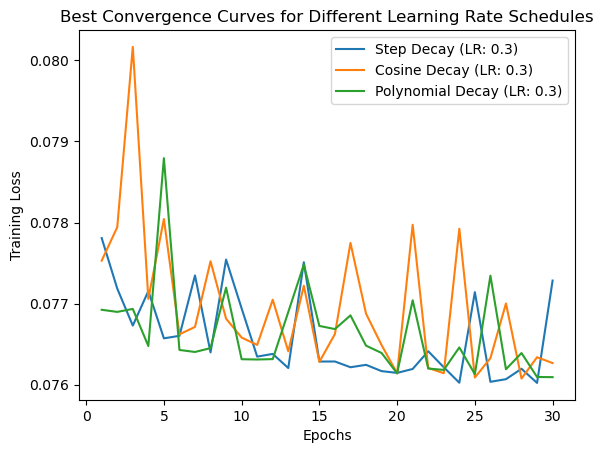

In [126]:
plt.plot(range(1, 31), best_curve_step, label=f'{"Step Decay"} (LR: {best_lr_step})')
plt.plot(range(1, 31), best_curve_cos, label=f'{"Cosine Decay"} (LR: {best_lr_cos})')
plt.plot(range(1, 31), best_curve_poly, label=f'{"Polynomial Decay"} (LR: {best_lr_poly})')
plt.title('Best Convergence Curves for Different Learning Rate Schedules')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.legend()
plt.show()